In [1]:
# Install gensim in Colab
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import zipfile

# Paths on Google Drive
csv_path = '/content/drive/MyDrive/Indian_judgements/reduced_judgements_clean.csv'
pdf_zip_path = '/content/drive/MyDrive/Indian_judgements/reduced_pdfs.zip'

# Extract ZIP to a folder in Colab
extracted_pdf_dir = '/content/reduced_pdfs'
os.makedirs(extracted_pdf_dir, exist_ok=True)

with zipfile.ZipFile(pdf_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_pdf_dir)

print("PDFs extracted to:", extracted_pdf_dir)


PDFs extracted to: /content/reduced_pdfs


In [3]:
import pandas as pd

# Load CSV
df = pd.read_csv(csv_path)

# Check columns
print("Columns in CSV:", list(df.columns))

# Preview first 5 rows
print("\nFirst few rows:")
print(df.head())


Columns in CSV: ['diary_no', 'case_no', 'judgment_dates', 'pdf_exists', 'pdf_path']

First few rows:
     diary_no                          case_no judgment_dates  pdf_exists  \
0  80384-1991                              - 0     10-03-1992        True   
1  18732-1998  Crl.A. No.-001258-001263 - 1999     26-11-1999        True   
2   7011-2000    C.A. No.-002551-002551 - 2001     20-02-2008        True   
3  25859-2004    C.A. No.-000584-000584 - 2008     22-01-2008        True   
4   9232-2003    C.A. No.-004227-004227 - 2003     03-09-2009        True   

                                            pdf_path  
0  /content/indian_judgments/pdfs/80384-1991___jo...  
1  /content/indian_judgments/pdfs/18732-1998___jo...  
2  /content/indian_judgments/pdfs/7011-2000___jon...  
3  /content/indian_judgments/pdfs/25859-2004___jo...  
4  /content/indian_judgments/pdfs/9232-2003___jon...  


In [4]:
# ===============================
# STEP 1: Setup & Imports
# ===============================
!pip install PyMuPDF tqdm

import os
import fitz  # PyMuPDF
from tqdm import tqdm
import pandas as pd

# ===============================
# STEP 2: Paths
# ===============================
csv_path = '/content/drive/MyDrive/Indian_judgements/reduced_judgements_clean.csv'
pdf_dir = '/content/reduced_pdfs'  # extracted ZIP folder

# ===============================
# STEP 3: Load CSV
# ===============================
df = pd.read_csv(csv_path)
print(" CSV loaded successfully!")
print("Columns in CSV:", list(df.columns))
print("\nPreview:")
print(df.head())

# Ensure the `pdf_path` column points to actual files in extracted folder
# (if your old paths were from /content/reduced_pdfs in previous run)
df['pdf_path'] = df['pdf_path'].apply(lambda x: os.path.join(pdf_dir, os.path.basename(str(x))))

# ===============================
# STEP 4: Filter & Extract Text from PDFs
# ===============================
df['judgements_text'] = ''

# Filter to only existing & non-empty PDFs
df = df[df['pdf_path'].apply(lambda x: os.path.exists(x) and os.path.getsize(x) > 0)].reset_index(drop=True)
print("📄 Total valid PDFs found:", len(df))

# Extract text from PDFs
for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting text"):
    pdf_path = row['pdf_path']
    text = ''
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                page_text = page.get_text()
                if page_text:
                    text += page_text + '\n'
    except Exception as e:
        print(f"❌ Error reading {pdf_path}: {e}")
    df.at[i, 'judgements_text'] = text

print("\n✅ Text extraction done for", len(df), "PDFs")

# ===============================
# STEP 5: Save extracted data
# ===============================
text_csv_path = '/content/judgements_with_text.csv'
text_parquet_path = '/content/judgements_with_text.parquet'

df.to_csv(text_csv_path, index=False)
df.to_parquet(text_parquet_path, index=False)

print(f"📁 Saved extracted data to:\nCSV: {text_csv_path}\nParquet: {text_parquet_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 78.8 MB/s eta 0:00:00
 CSV loaded successfully!
Columns in CSV: ['diary_no', 'case_no', 'judgment_dates', 'pdf_exists', 'pdf_path']

Preview:
     diary_no                          case_no judgment_dates  pdf_exists  \
0  80384-1991                              - 0     10-03-1992        True   
1  18732-1998  Crl.A. No.-001258-001263 - 1999     26-11-1999        True   
2   7011-2000    C.A. No.-002551-002551 - 2001     20-02-2008        True   
3  25859-2004    C.A. No.-000584-000584 - 2008     22-01-2008        True   
4   9232-2003    C.A. No.-004227-004227 - 2003     03-09-2009        True   

                                            pdf_path  
0  /content/indian_judgments/pdfs/80384-1991___jo...  
1  /content/indian_judgments/pdfs/18732-1998___jo...  
2  /content/indian_judgments/pdfs/7011-2000___jon...  
3  /content/indian_judgments/pdfs/25859-2004___jo...  
4  /content/indian_judgments/pdfs/9232-2003___jon...  
📄 Total 

Extracting text: 100%|██████████| 1879/1879 [01:12<00:00, 25.84it/s]



✅ Text extraction done for 1879 PDFs
📁 Saved extracted data to:
CSV: /content/judgements_with_text.csv
Parquet: /content/judgements_with_text.parquet


In [5]:
# Save extracted data directly to Google Drive
text_csv_path = '/content/drive/MyDrive/Indian_judgements/judgements_with_text.csv'
text_parquet_path = '/content/drive/MyDrive/Indian_judgements/judgements_with_text.parquet'

df.to_csv(text_csv_path, index=False)
df.to_parquet(text_parquet_path, index=False)

print(f"✅ Saved to Google Drive:\n{text_csv_path}\n{text_parquet_path}")


✅ Saved to Google Drive:
/content/drive/MyDrive/Indian_judgements/judgements_with_text.csv
/content/drive/MyDrive/Indian_judgements/judgements_with_text.parquet


In [6]:
from google.colab import files
files.download('/content/judgements_with_text.csv')
files.download('/content/judgements_with_text.parquet')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# ===============================
# STEP 0: Install & Imports
# ===============================
!pip install PyMuPDF tqdm gensim pyLDAvis

import os
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim import corpora
from gensim.models import LdaModel
import numpy as np


# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



# ===============================
# STEP 2: Preprocessing Setup
# ===============================
stop_words = set(stopwords.words('english'))

# Add modal verbs and legal/common words
legal_stopwords = {
    # Parties & roles
    'petitioner', 'respondent', 'appellant', 'defendant', 'plaintiff', 'accused',
    'party', 'parties', 'counsel', 'advocate', 'attorney', 'prosecutor', 'applicant',

    # Court terms
    'court', 'bench', 'judgment', 'order', 'proceedings', 'hearing', 'case',
    'matter', 'petition', 'claim', 'verdict', 'decision', 'act', 'section', 'clause',

    # Legal procedures
    'filed', 'plea', 'petitioners', 'respondents', 'submitted', 'allowed',
    'dismissed', 'granted', 'rejected', 'challenged', 'reviewed', 'appeal',

    # Common legal words
    'law', 'rights', 'regulation', 'rule', 'statute', 'provision', 'authority',
    'legal', 'liable', 'responsible', 'application', 'objection', 'record',

    # Modals & connectors
    'shall', 'may', 'would', 'could', 'should', 'must', 'might'
}
stop_words.update(legal_stopwords)

lemmatizer = WordNetLemmatizer()
CHUNK_WORDS = 400
OVERLAP = 50

# ===============================
# STEP 3: Preprocessing Function
# ===============================
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Fix hyphens inside words (names-che -> names che)
    text = re.sub(r'(\w)-(\w)', r'\1 \2', text)

    # Remove line breaks & extra spaces
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Remove URLs, numbers, punctuation
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove capitalized words (heuristic proper nouns)
    tokens = [w for w in tokens if not w[0].isupper()]

    # Lowercase, remove stopwords, lemmatize, remove short words
    tokens = [
        lemmatizer.lemmatize(w.lower())
        for w in tokens
        if w.lower() not in stop_words and len(w) > 2
    ]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['judgements_text'].apply(preprocess_text)

# ===============================
# STEP 4: Chunking Function
# ===============================
def chunk_text_sliding_words(text, chunk_size=CHUNK_WORDS, overlap=OVERLAP):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return []

    words = text.split()
    if len(words) <= chunk_size:
        return [" ".join(words)]

    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunks.append(" ".join(words[start:end]))
        if end == len(words):
            break
        start += (chunk_size - overlap)
    return chunks

# Apply chunking
df['text_chunks'] = df['processed_text'].apply(chunk_text_sliding_words)

# Explode chunks into separate rows
df_chunks = df.explode('text_chunks').reset_index(drop=True)
df_chunks = df_chunks[['diary_no', 'text_chunks']]

print("\n✅ Preprocessing and chunking done!")

# ===============================
# STEP 5: Preview first 2 judgments & chunks
# ===============================
first_two_diary_nos = df_chunks['diary_no'].unique()[:2]

for diary_no in first_two_diary_nos:
    print(f"\n=== Chunks for Judgment {diary_no} ===\n")

    chunks = df_chunks[df_chunks['diary_no'] == diary_no]['text_chunks'].tolist()

    for i, chunk in enumerate(chunks, 1):
        print(f"--- Chunk {i} ({len(chunk.split())} words) ---")
        print(chunk[:500] + ("..." if len(chunk) > 500 else ""))
        print()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



✅ Preprocessing and chunking done!

=== Chunks for Judgment 80384-1991 ===

--- Chunk 1 (400 words) ---
qualification exercise jurisdiction ground incumbent fulfill qualification required dated appointed procedure officer administer justice power analogous judicial hold judicial office judiciary justice assume jurisdiction judicial side probe purely administrative nature exclusively within purview serviceinterpretation letter dated addressed recommended name appointment bio data enclosed said letter indicated passing joined worked various post appointed worked also worked certain bio data describe...

--- Chunk 2 (400 words) ---
eligible appointed scheme clear independence judiciary part basic structure achieve objective separation judiciary executive framer meant judicial office exist independently duty part duty conferred person whether trained administration justice enshrined give mandate take step separate judiciary executive mean separate judicial service free executive control p

In [8]:
first_two_diary_nos = df_chunks['diary_no'].unique()[:2]

for diary_no in first_two_diary_nos:
    print(f"\n=== Chunks for Judgment {diary_no} ===\n")

    chunks = df_chunks[df_chunks['diary_no'] == diary_no]['text_chunks'].tolist()

    for i, chunk in enumerate(chunks, 1):
        print(f"--- Chunk {i} ({len(chunk.split())} words) ---")
        print(chunk[:500] + ("..." if len(chunk) > 500 else ""))
        print()



=== Chunks for Judgment 80384-1991 ===

--- Chunk 1 (400 words) ---
qualification exercise jurisdiction ground incumbent fulfill qualification required dated appointed procedure officer administer justice power analogous judicial hold judicial office judiciary justice assume jurisdiction judicial side probe purely administrative nature exclusively within purview serviceinterpretation letter dated addressed recommended name appointment bio data enclosed said letter indicated passing joined worked various post appointed worked also worked certain bio data describe...

--- Chunk 2 (400 words) ---
eligible appointed scheme clear independence judiciary part basic structure achieve objective separation judiciary executive framer meant judicial office exist independently duty part duty conferred person whether trained administration justice enshrined give mandate take step separate judiciary executive mean separate judicial service free executive control part provide subordinate court scheme

In [9]:
df.columns

Index(['diary_no', 'case_no', 'judgment_dates', 'pdf_exists', 'pdf_path',
       'judgements_text', 'processed_text', 'text_chunks'],
      dtype='object')

In [ ]:
!pip install -q gensim==4.3.1 nltk tqdm

In [10]:
import os, random, multiprocessing
import numpy as np, pandas as pd
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [23]:
base_dir = "/content/drive/MyDrive/Indian_judgements"
paths = [
    os.path.join(base_dir, "judgements_with_text.parquet"),
    os.path.join(base_dir, "reduced_judgements_clean.csv"),
    os.path.join(base_dir, "reduced_judgments.csv"),
]

df = None
for p in paths:
    if os.path.exists(p):
        print(f"Loading file: {p}")
        if p.endswith(".parquet"):
            df = pd.read_parquet(p)
        else:
            df = pd.read_csv(p)
        break

if df is None:
    raise FileNotFoundError(" No judgments file found in indian_judgments/ folder!")

print(" Loaded dataframe:", df.shape)
df.columns = [c.lower().strip() for c in df.columns]
df.head(2)


Loading file: /content/drive/MyDrive/Indian_judgements/judgements_with_text.parquet
 Loaded dataframe: (1879, 6)


,diary_no,case_no,judgment_dates,pdf_exists,pdf_path,judgements_text
0,80384-1991,- 0,10-03-1992,True,/content/reduced_pdfs/80384-1991___jonew__judi...,http://JUDIS.NIC.IN \nSUPREME COURT OF INDIA\n...
1,7011-2000,C.A. No.-002551-002551 - 2001,20-02-2008,True,/content/reduced_pdfs/7011-2000___jonew__judis...,http://JUDIS.NIC.IN \nSUPREME COURT OF INDIA\n...


In [24]:
# Re-run preprocessing and chunking
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from tqdm import tqdm

# Download NLTK resources (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
CHUNK_WORDS = 400
OVERLAP = 50

# Preprocessing Function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Remove line breaks, extra spaces
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Remove URLs, numbers, punctuation
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove capitalized words (heuristic proper nouns)
    tokens = text.split()
    tokens = [w for w in tokens if not w[0].isupper()]

    # Lowercase
    tokens = [w.lower() for w in tokens]

    # Remove stopwords, lemmatize, remove short words
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['judgements_text'].apply(preprocess_text)

# Chunking Function
def chunk_text_sliding_words(text, chunk_size=CHUNK_WORDS, overlap=OVERLAP):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return []

    words = text.split()
    if len(words) <= chunk_size:
        return [" ".join(words)]

    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunks.append(" ".join(words[start:end]))
        if end == len(words):
            break
        start += (chunk_size - overlap)
    return chunks

# Apply chunking
df['text_chunks'] = df['processed_text'].apply(chunk_text_sliding_words)
df_chunks = df.explode('text_chunks').reset_index(drop=True)
df_chunks = df_chunks[['diary_no', 'text_chunks']]

print("Preprocessing and chunking complete.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing and chunking complete.


In [26]:
# Manually define columns
id_col = "diary_no"
text_col = "processed_text"

# Basic cleaning
df[text_col] = df[text_col].astype(str)
df = df[df[text_col].str.strip().astype(bool)].reset_index(drop=True)

print(f"Using text column: {text_col}, id column: {id_col}")
print("Documents after cleaning:", len(df))


Using text column: processed_text, id column: diary_no
Documents after cleaning: 1860


In [27]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab") # Add this line to download the missing resource
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def simple_tokenize(text):
    toks = word_tokenize(text.lower())
    toks = [t for t in toks if t.isalpha() and len(t) > 2 and t not in stops]
    return toks

print("🔁 Tokenizing texts...")
df["tokens"] = [simple_tokenize(t) for t in tqdm(df[text_col])]
df["n_tokens"] = df["tokens"].apply(len)
df = df[df["n_tokens"] >= 10].reset_index(drop=True)
print("✅ Kept", len(df), "documents with ≥10 tokens.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


🔁 Tokenizing texts...


100%|██████████| 1860/1860 [00:08<00:00, 219.74it/s]

✅ Kept 1854 documents with ≥10 tokens.


In [28]:
tagged_docs = [
    TaggedDocument(words=row['tokens'], tags=[f"DOC_{row[id_col]}"])
    for _, row in df.iterrows()
]

vector_size = 300
model = Doc2Vec(
    vector_size=vector_size,
    window=10,
    min_count=3,
    dm=1,  # PV-DM
    workers=max(1, multiprocessing.cpu_count() - 1),
    epochs=40,
    seed=SEED,
)

print("📚 Building vocabulary...")
model.build_vocab(tagged_docs)
print("🚀 Training Doc2Vec model...")
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

model_path = "/content/drive/MyDrive/Indian_judgements/models/doc2vec_scj.model"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

model.save(model_path)
print("✅ Model saved at:", model_path)

📚 Building vocabulary...
🚀 Training Doc2Vec model...
✅ Model saved at: /content/drive/MyDrive/Indian_judgements/models/doc2vec_scj.model


In [29]:
doc_tags = [f"DOC_{v}" for v in df[id_col].astype(str)]
vectors = np.vstack([model.dv[tag] for tag in doc_tags])

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
df["doc2vec_cluster"] = kmeans.fit_predict(vectors)

# Optional metrics
try:
    sil = silhouette_score(vectors, df["doc2vec_cluster"])
except Exception:
    sil = None
db = davies_bouldin_score(vectors, df["doc2vec_cluster"])
print(f"📊 Silhouette Score: {sil}")
print(f"📊 Davies-Bouldin Score: {db}")

📊 Silhouette Score: 0.02740400657057762
📊 Davies-Bouldin Score: 4.818622004337647


In [30]:
# Define semantic labels for clusters
semantic_labels = {
    0: "Constitutional Law",
    1: "Administrative/Service Law",
    2: "Tax/Corporate Law",
    3: "Civil Law",
    4: "Criminal Law",
    5: "Labour/Employment Law"
}

# Map numeric clusters to semantic category names
df["category_name"] = df["doc2vec_cluster"].map(semantic_labels)

# Select only ID and category columns for output
out_cols = [id_col]
if "case_no" in df.columns:
    out_cols.append("case_no")
out_cols += ["category_name"]

# Save the final CSV
out_path_named = "/content/drive/MyDrive/Indian_judgements/doc2vec_output_predictions_named.csv"
os.makedirs(os.path.dirname(out_path_named), exist_ok=True)
df[out_cols].to_csv(out_path_named, index=False)

print("✅ Saved predictions with semantic category names only to:", out_path_named)
df[out_cols].head()


✅ Saved predictions with semantic category names only to: /content/drive/MyDrive/Indian_judgements/doc2vec_output_predictions_named.csv


,diary_no,case_no,category_name
0,80384-1991,- 0,Constitutional Law
1,7011-2000,C.A. No.-002551-002551 - 2001,Civil Law
2,25859-2004,C.A. No.-000584-000584 - 2008,Civil Law
3,9232-2003,C.A. No.-004227-004227 - 2003,Civil Law
4,60150-1957,- 0,Administrative/Service Law


In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(vectors, df["doc2vec_cluster"])
dbi = davies_bouldin_score(vectors, df["doc2vec_cluster"])
chi = calinski_harabasz_score(vectors, df["doc2vec_cluster"])

print("📊 Clustering Metrics for Doc2Vec")
print(f"Silhouette Score: {silhouette:.3f} (higher is better)")
print(f"Davies–Bouldin Index: {dbi:.3f} (lower is better)")
print(f"Calinski–Harabasz Index: {chi:.3f} (higher is better)")


📊 Clustering Metrics for Doc2Vec
Silhouette Score: 0.027 (higher is better)
Davies–Bouldin Index: 4.819 (lower is better)
Calinski–Harabasz Index: 73.790 (higher is better)


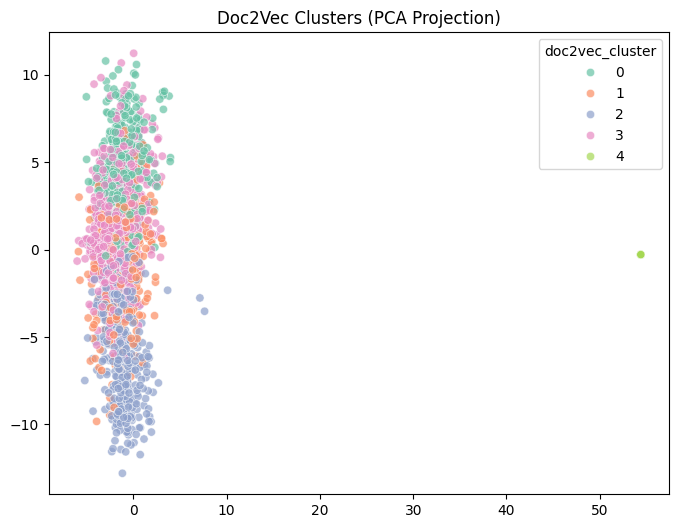

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


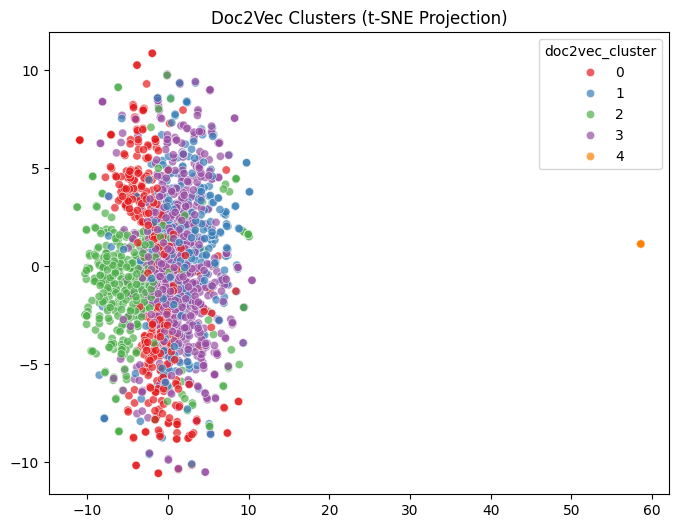

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# PCA 2D Projection
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(vectors)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_pca[:,0], y=reduced_pca[:,1], hue=df["doc2vec_cluster"], palette="Set2", alpha=0.7)
plt.title("Doc2Vec Clusters (PCA Projection)")
plt.show()

# t-SNE 2D Projection
tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=2000)
reduced_tsne = tsne.fit_transform(vectors)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_tsne[:,0], y=reduced_tsne[:,1], hue=df["doc2vec_cluster"], palette="Set1", alpha=0.7)
plt.title("Doc2Vec Clusters (t-SNE Projection)")
plt.show()


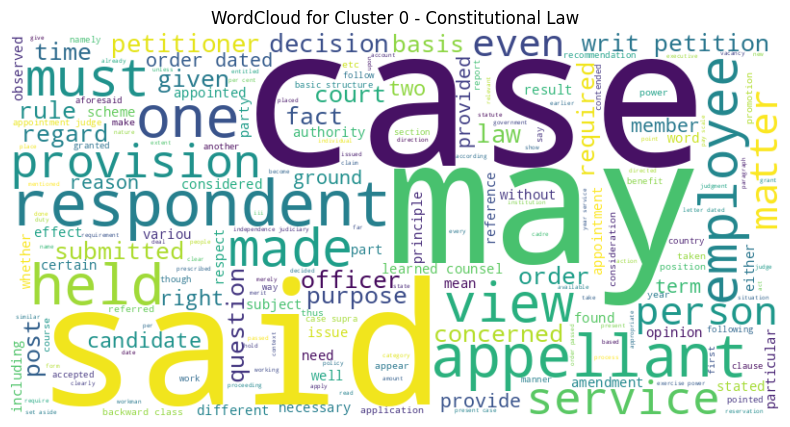

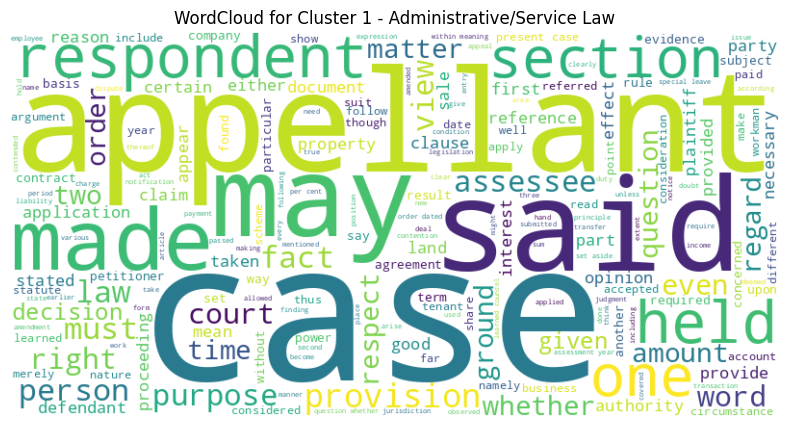

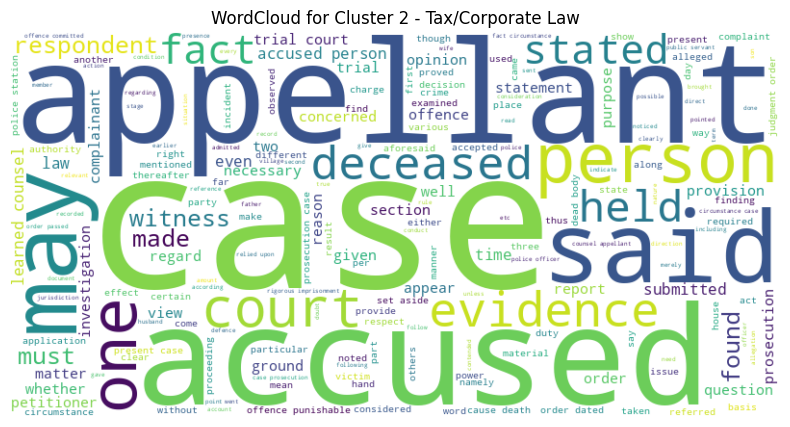

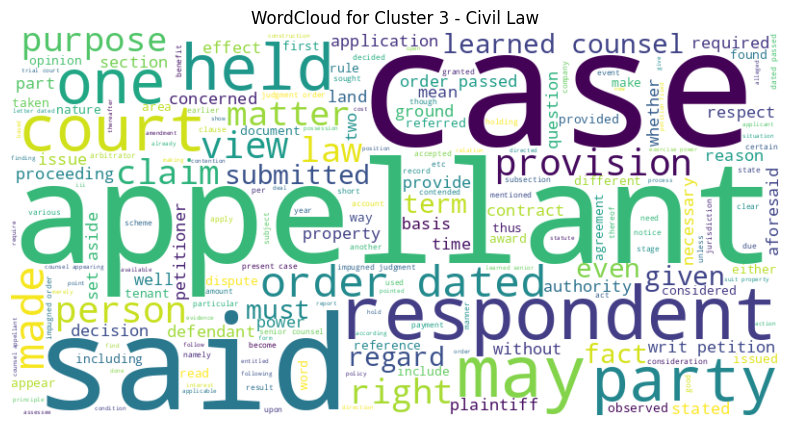

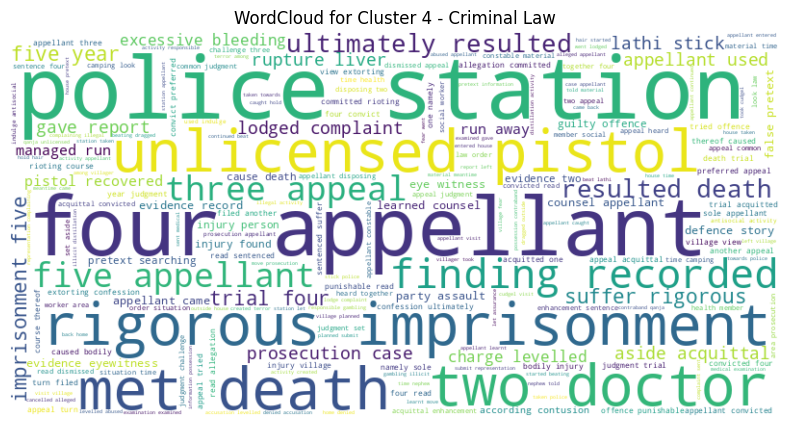

In [21]:
from wordcloud import WordCloud

for cluster in sorted(df["doc2vec_cluster"].unique()):
    cluster_text = " ".join(df[df["doc2vec_cluster"] == cluster]["processed_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(cluster_text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for Cluster {cluster} - {semantic_labels.get(cluster, 'Unknown')}")
    plt.show()


/tmp/ipython-input-3979002983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["cluster_category"], palette="Set3",


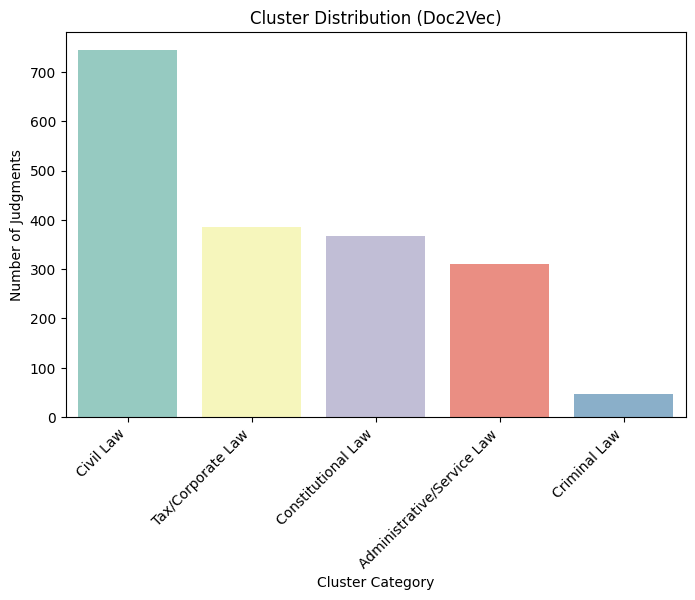

In [23]:
# Map cluster IDs to category names
df["cluster_category"] = df["doc2vec_cluster"].map(semantic_labels)

plt.figure(figsize=(8,5))
sns.countplot(x=df["cluster_category"], palette="Set3",
              order=df["cluster_category"].value_counts().index)

plt.title("Cluster Distribution (Doc2Vec)")
plt.xlabel("Cluster Category")
plt.ylabel("Number of Judgments")
plt.xticks(rotation=45, ha="right")
plt.show()
